# Query optimization of relational algebra in Python.

Copyright Jens Dittrich & Felix Martin Schuhknecht & Marcel Maltry [Big Data Analytics Group](https://bigdata.uni-saarland.de/), [CC-BY-SA](https://creativecommons.org/licenses/by-sa/4.0/legalcode)

## Rule-based Optimization

### Imports and Setup

In [1]:
from graphviz import Digraph, Source
from ra.relation import Relation
from ra.utils import load_csv
from ra.operators_log import *
from ra.operators_phys import *
from ra.rule import *
from ra.rules_log import *
from ra.rules_phys import *

import copy

In [2]:
from os import listdir

# Data source: https://relational.fit.cvut.cz/dataset/IMDb
# Information courtesy of IMDb (http://www.imdb.com). Used with permission.
# Notice: The data can only be used for personal and non-commercial use and must not
# be altered/republished/resold/repurposed to create any kind of online/offline
# database of movie information (except for individual personal use).

path = 'data/IMDb_sample'  
# create a list of all files in that directory that end with "*.csv":
files = [file for file in listdir(path) if file.endswith('.csv')]

relations = [load_csv(path + '/' + file, file[:-4], delimiter='\t') for file in files]

relationsDict = {}
for rel in relations:
    relationsDict[rel.name] = rel
print(relationsDict)

{'movies_directors': ----------------
movies_directors 
--------------------------
director_id  movie_id      
--------------------------
43095        121538       
78273        223710       
78273        118367       
78273        164572       
78273        267038       
43095        299073       
11652        10920        
11652        333856       
78273        176711       
43095        291833       

actors 
--------------------------------------------------------------------------------------------
id                     first_name             last_name              gender                  
--------------------------------------------------------------------------------------------
452838                 Burr                   Steers                 M                      
54507                  Buff                   Brady                  M                      
363245                 James                  Parks                  M                      
331537                 W

In [3]:
# build LeafRelation object from relations dictionary
movies_directors = LeafRelation(relationsDict['movies_directors'])
actors = LeafRelation(relationsDict['actors'])
directors = LeafRelation(relationsDict['directors'])
movies_genres = LeafRelation(relationsDict['movies_genres'])
directors_genres = LeafRelation(relationsDict['directors_genres'])
movies = LeafRelation(relationsDict['movies'])
roles = LeafRelation(relationsDict['roles'])

In [4]:
# build indexes
#directors_genres.relation.build_index('genre')
#directors_genres.relation.build_index('prob')

### Example

An example for an unoptimized logical operator tree (aka **canonical plan**):

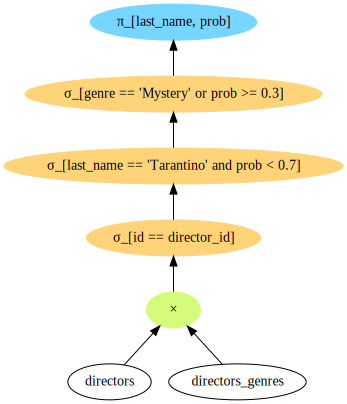

In [5]:
# Unoptimized plan
cp = Cartesian_Product(directors, directors_genres)
sel1 = Selection(cp, 'id == director_id')
sel2 = Selection(sel1, 'last_name == \'Tarantino\' and prob < 0.7')
sel3 = Selection(sel2, 'genre == \'Mystery\' or prob >= 0.3')
proj = Projection(sel3, 'last_name, prob')

graph = proj.get_graph()
graph

### Optimization 1: Break up 'and' selections

Replace every conjunction, i.e. selection of the form (A and B and C), with a chain of individual selections of the form (A), (B), (C). This optimization enables a fine-granular selection pushdown (Optimization 2).

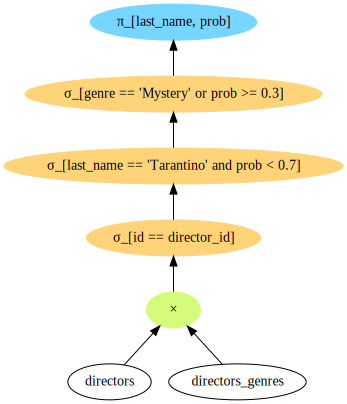

In [6]:
# before optimization
graph = proj.get_graph()
graph

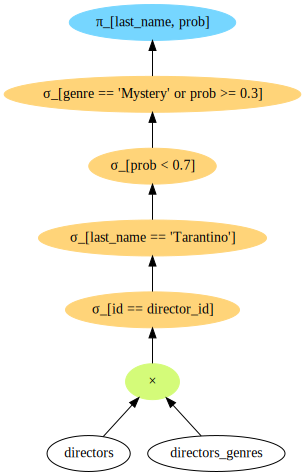

In [7]:
bus = BreakUpSelections(proj) 
bus.optimize(proj)

# after optimization
graph = bus.root.get_graph()
graph

### Optimization 2: Push down selections

Push down every selection as far as possible in the operator tree. This assures the early elimination of tuples. We assume that optimization 1 has been applied already.

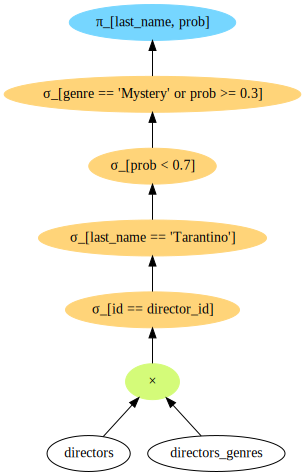

In [8]:
# before optimization
graph = bus.root.get_graph()
graph

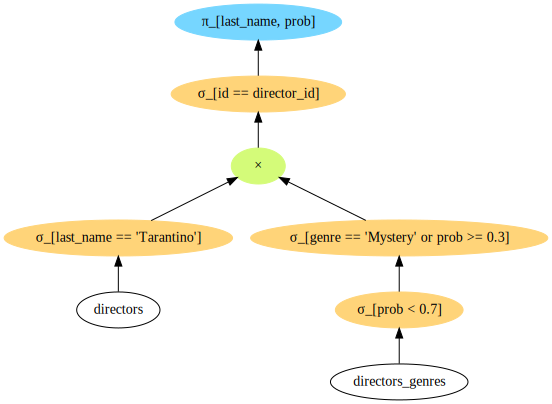

In [9]:
pds = PushDownSelection(bus.root) 
pds.optimize(bus.root)

# after optimization
graph = pds.root.get_graph()
graph

### Optimization 3: Replace a join-style selection on top of a cartesian product by a theta join 

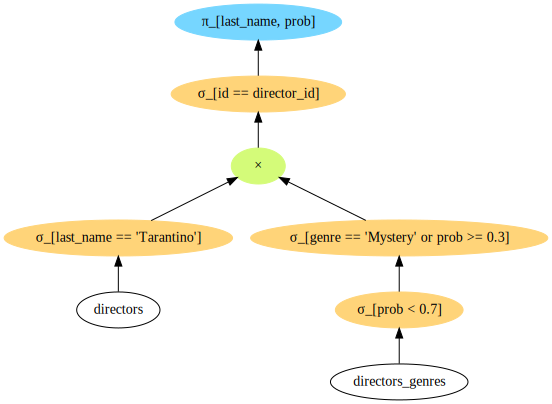

In [10]:
# before optimization
graph = pds.root.get_graph()
graph

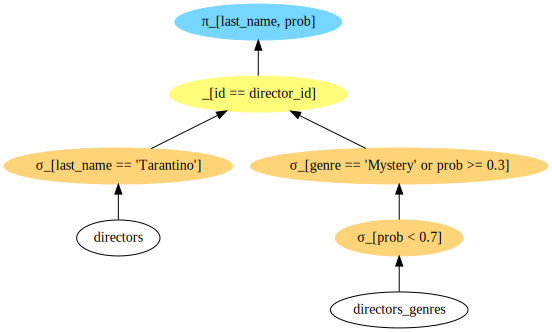

In [11]:
rbj = ReplaceByJoin(pds.root) 
rbj.optimize(pds.root)

# after optimization
graph = rbj.root.get_graph()
graph

### Optimization 4: Insert projections

Project only the attributes, that are needed upwards the tree

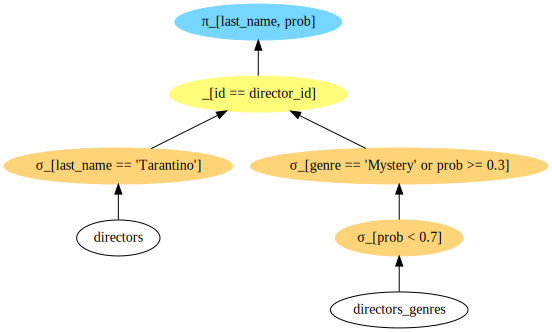

In [12]:
# before optimization
graph = rbj.root.get_graph()
graph

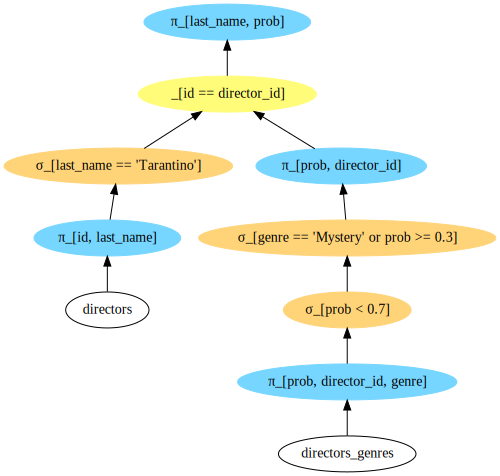

In [13]:
ip = InsertProjection(rbj.root) 
ip.optimize(rbj.root)

# after optimization
graph = ip.root.get_graph()
graph